In [152]:
import numpy as np
import pickle as pkl
import glob
import matplotlib.pyplot as plt

In [153]:
path = './out_london/'
animal = 'ST264'
dayN = 1
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
beh = 5 #number of behavioural variables
list_files = glob.glob(path+exp_pref+"*.pkl")

In [154]:
list_files

['./out_london/ST264_Day1_1020_models.pkl',
 './out_london/ST264_Day1_0_models.pkl']

### First merge pkls

In [155]:
#del(data)
def fix_zero_times(entry):
    # this function deletes stopped or broken runs
    if (entry!=None):
        if (entry[-1]==0):# & (entry[1]!='Independence'):
            return None
        else:
            return entry
    else:
        return None

with open(list_files[0],'rb') as f:
    new_data = pkl.load(f)
data_pkls = np.empty_like(new_data) #create an empty list
for file in list_files:
    with open(file,'rb') as f:
        new_data = pkl.load(f)
        new_data = np.array([[fix_zero_times(j) for j in i] for i in new_data])
        # it is important to fix the data(above) before adding to the results
        #check rewrites
        rewrite_rule = (new_data!=None) & (data_pkls!=None)
        rewrite_new = new_data[rewrite_rule]
        if len(rewrite_new)>0:
            overwrite = data_pkls[rewrite_rule]
            X,Y = np.mgrid[0:new_data.shape[0],0:new_data.shape[1]]
            for old_el,new_el,x,y in zip(overwrite,rewrite_new,X[rewrite_rule],Y[rewrite_rule]):
                print('Overwrite {}({}) with {}({}) at {}-{}'.format(
                    old_el[1],old_el[2],
                    new_el[1],new_el[2],
                    x-beh,y-beh
                    ))
                print(new_el[-1])
        #add results
        data_pkls[new_data!=None] = new_data[new_data!=None]

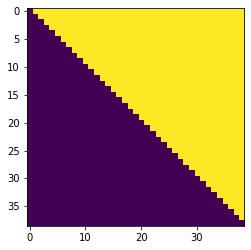

In [163]:
plt.imshow((data_pkls!=None)*1.0)

### Next check last records on a model list

In [164]:
#parse text results

def neuron_ids(string):
    arr = str.split(string,sep='-')
    n1,n2 = 1,1
    which = 0
    for a in arr:
        try:
            n = int(a)
            if which:
                n2*=n
            else:
                n1*=n
                which=1
        except ValueError:
            if which:
                n2 = -1
            else:
                n1 = -1
    return n1,n2

import csv

beh = 5
NN = data_pkls.shape[0]-beh
data_txt = np.empty((NN+beh,NN+beh),dtype=object)

with open(path+animal+'_'+day_name+'_model_list.txt','r') as f:
    next(f) # skip headings
    reader=csv.reader(f,delimiter='\t')
    for res,waic,time in reader:
        neuron, copula = str.split(res)
        n1,n2 = neuron_ids(neuron)
        if time!=0:
            data_txt[n1+beh,n2+beh] = [copula,waic,time,n1,n2]

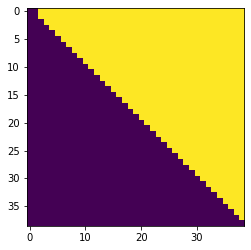

In [165]:
plt.imshow((data_txt!=None)*1.0)

In [168]:
# #repair lost pkls
# from select_copula import elements
# from utils import get_copula_name_string

# def create_copula_dict(elements):
#     d = {}
#     for el1 in elements:
#         d[get_copula_name_string([el1])] = [el1]
#         for el2 in elements:
#             d[get_copula_name_string([el1,el2])] = [el1,el2]
#             for el3 in elements:
#                 d[get_copula_name_string([el1,el2,el3])] = [el1,el2,el3]
#     return d

# copula_dict = create_copula_dict(elements)


# for n1 in range(0,NN-1+beh):
#     for n2 in range(n1+1,NN+beh):
#         if (data_pkls[n1,n2]==None) & (data_txt[n1,n2]!=None):
#             data_pkls[n1,n2] = [copula_dict[data_txt[n1,n2][0]],data_txt[n1,n2][0],
#                                 float(data_txt[n1,n2][1]), int(data_txt[n1,n2][2])]
#         elif (data_pkls[n1,n2]!=None):
#             if data_pkls[n1,n2][1]!=data_txt[n1,n2][0]:
#                 print('What? {}-{}'.format(n1,n2))

### Now check that everything is merged correctly and save

In [169]:
def check_data_merge(data_pkls, data_txt):
    err = 0
    for pkls,txt in zip(data_pkls.flatten(), data_txt.flatten()):
        if pkls!=None:
            assert txt!=None
            if pkls[1]!=txt[0]:
                err = 1
        #    print(pkl[1],txt[0],pkl[2],txt[1],txt[-2],txt[-1])
    return err

In [170]:
def try_copy(source,target):
    try:
        os.path.exists(source)
    except FileExistsError as error:
        print(error)
        return 0
    finally:
        os.popen('cp {} {}'.format(source,target)) 
        return 1
        
def copy_all_weights(data,in_dir,out_dir):
    for i in range(data.shape[0]):
        for j in range(i+1,data.shape[1]):
            if data[i,j]!=None:
                if data[i,j][1]!='Independence':
                    name = '{}-{}'.format(i-beh,j-beh)
                    source = '{}/model*_{}.pth'.format(in_dir,name)
                    target = '{}/model_{}.pth'.format(out_dir,name)
                    assert try_copy(source,target)
                    source = '{}/best*_{}.png'.format(in_dir,name)
                    target = '{}/figs/best_{}.png'.format(out_dir,name)
                    assert try_copy(source,target)
    with open(out_dir+'/summary.pkl','wb') as f:
        pkl.dump(data,f)

In [171]:
import os

upper_ones = np.triu(np.ones(data_pkls.shape[0]))-np.diag(np.ones(data_pkls.shape[0]))

out_dir = '../models/'+exp_pref
try:
    os.mkdir(out_dir)
    os.mkdir(out_dir+'/figs/')
except FileExistsError as error:
    list_files = glob.glob(out_dir+"*.p*")
    if len(list_files):
        raise Exception("Folder not empty, save nothing")

assert check_data_merge(data_pkls, data_txt)==0
assert np.all(1*(data_pkls!=None) == upper_ones) #check that all results exist
# if folder is empty and all merged well -- save
copy_all_weights(data_pkls,path+exp_pref,out_dir)